# Отчет по лабораторной работе №3
## Реализация алгоритма обратного распространения ошибки

## 1. Цель работы и задачи

**Цель**: Получить практические навыки реализации и обучения полносвязной нейронной сети с нуля на языке Python с использованием объектно-ориентированного подхода, применяя алгоритм обратного распространения ошибки и градиентный спуск на мини-батчах для задачи бинарной классификации.

**Задачи**:
1. Изучить теоретические основы алгоритма обратного распространения ошибки и градиентного спуска на мини-батчах.
2. Реализовать класс `NeuralNetwork`, инкапсулирующий структуру и методы полносвязной нейронной сети.
3. Реализовать функции активации (Sigmoid, ReLU, Tanh) и их производные.
4. Реализовать метод прямого распространения сигнала (`_forward`).
5. Реализовать метод вычисления функции потерь (`_compute_cost`) с использованием перекрестной энтропии.
6. Реализовать метод обратного распространения ошибки (`_backward`) для вычисления градиентов.
7. Реализовать метод обновления параметров (`_update_parameters`) feasibly using mini-batches (`fit`) и предсказания (`predict`).
8. Протестировать сеть на синтетическом наборе данных `make_moons` и визуализировать результаты.


## Суворов Роман ИВТ 2.1

# Лабораторная работа: Реализация алгоритма обратного распространения ошибки

**Цель:** Реализовать с нуля полносвязную нейронную сеть на Python с использованием объектно-ориентированного подхода и обучить её с помощью алгоритма обратного распространения ошибки на мини-батчах.

**Задачи:**
1. Реализовать класс `NeuralNetwork`.
2. Реализовать функции активации (Sigmoid, ReLU, Tanh) и их производные.
3. Реализовать методы прямого распространения (`_forward`).
4. Реализовать метод вычисления функции потерь (`_compute_cost`).
5. Реализовать метод обратного распространения ошибки (`_backward`).
6. Реализовать метод обновления параметров (`_update_parameters`).
7. Реализовать метод обучения (`fit`) с использованием мини-батчей.
8. Реализовать метод предсказания (`predict`).
9. Протестировать реализацию на простом наборе данных.

## 1. Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

## 2. Реализация вспомогательных функций и класса нейронной сети

Ниже приведены вспомогательные функции активации и структура класса `NeuralNetwork`.

In [2]:

def sigmoid(z):
    """Сигмоидная функция активации."""
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Производная сигмоидной функции."""
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU функция активации."""
    return np.maximum(0, z)

def relu_derivative(z):
    """Производная ReLU функции."""
    return np.where(z > 0, 1.0, 0.0)

def tanh(z):
    """Гиперболический тангенс функция активации."""
    return np.tanh(z)

def tanh_derivative(z):
    """Производная гиперболического тангенса."""
    return 1 - np.tanh(z)**2

ACTIVATIONS = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative)
}

class NeuralNetwork:
    """Класс полносвязной нейронной сети с обучением по mini-batches."""
    
    def __init__(self, layer_dims, activation_funcs, learning_rate=0.01):
        if len(layer_dims) < 2:
            raise ValueError("Сеть должна иметь как минимум входной и выходной слои.")
        if len(activation_funcs) != len(layer_dims) - 1:
            raise ValueError("Количество функций активации должно соответствовать количеству слоев (исключая входной).")
            
        self.num_layers = len(layer_dims)
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.parameters = {}
        self.activation_funcs = {}

        np.random.seed(42)
        for l in range(1, self.num_layers):
            if activation_funcs[l-1] == 'relu':
                self.parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2. / layer_dims[l-1])
            else:
                limit = np.sqrt(6. / (layer_dims[l-1] + layer_dims[l]))
                self.parameters[f'W{l}'] = np.random.uniform(-limit, limit, (layer_dims[l], layer_dims[l-1]))
            self.parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
            activation_name = activation_funcs[l-1]
            if activation_name not in ACTIVATIONS:
                raise ValueError(f"Неизвестная функция активации: {activation_name}")
            self.activation_funcs[l] = ACTIVATIONS[activation_name]

    def _forward(self, X):
        cache = {}
        A = X
        cache["A0"] = A

        for l in range(1, self.num_layers):
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']
            activation_func, _ = self.activation_funcs[l]
            A_prev = A
            Z = np.dot(W, A_prev) + b
            A = activation_func(Z)
            cache[f'Z{l}'] = Z
            cache[f'A{l}'] = A

        A_last = A
        return A_last, cache

    def _compute_cost(self, A_last, Y):
        m = Y.shape[1]
        epsilon = 1e-8
        cost = -(1/m) * np.sum(Y * np.log(A_last + epsilon) + (1 - Y) * np.log(1 - A_last + epsilon))
        cost = np.squeeze(cost)
        assert(cost.shape == ())
        return cost

    def _backward(self, A_last, Y, cache):
        grads = {}
        m = Y.shape[1]
        L = self.num_layers - 1
        epsilon = 1e-8

        dA_last = - (Y / (A_last + epsilon) - (1 - Y) / (1 - A_last + epsilon))
        Z_last = cache[f'Z{L}']
        A_prev = cache[f'A{L-1}']
        _, activation_derivative = self.activation_funcs[L]
        dZ_last = dA_last * activation_derivative(Z_last)
        grads[f'dW{L}'] = (1/m) * np.dot(dZ_last, A_prev.T)
        grads[f'db{L}'] = (1/m) * np.sum(dZ_last, axis=1, keepdims=True)
        W_last = self.parameters[f'W{L}']
        dA_prev = np.dot(W_last.T, dZ_last)

        for l in range(L-1, 0, -1):
            Z = cache[f'Z{l}']
            A_prev_l = cache[f'A{l-1}']
            _, activation_derivative = self.activation_funcs[l]
            dZ = dA_prev * activation_derivative(Z)
            grads[f'dW{l}'] = (1/m) * np.dot(dZ, A_prev_l.T)
            grads[f'db{l}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            W_current = self.parameters[f'W{l}']
            dA_prev = np.dot(W_current.T, dZ)

        return grads

    def _update_parameters(self, grads):
        for l in range(1, self.num_layers):
            self.parameters[f'W{l}'] -= self.learning_rate * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.learning_rate * grads[f'db{l}']

    def fit(self, X_train, Y_train, epochs, batch_size, print_cost_every=100):
        costs = []
        m = X_train.shape[1]
        np.random.seed(1)

        for epoch in range(epochs):
            epoch_cost = 0.
            permutation = np.random.permutation(m)
            shuffled_X = X_train[:, permutation]
            shuffled_Y = Y_train[:, permutation]
            num_minibatches = m // batch_size
            if m % batch_size != 0:
                num_minibatches += 1

            for i in range(num_minibatches):
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, m)
                mini_batch_X = shuffled_X[:, start_idx:end_idx]
                mini_batch_Y = shuffled_Y[:, start_idx:end_idx]
                A_last, cache = self._forward(mini_batch_X)
                batch_cost = self._compute_cost(A_last, mini_batch_Y)
                epoch_cost += batch_cost * mini_batch_X.shape[1]
                grads = self._backward(A_last, mini_batch_Y, cache)
                self._update_parameters(grads)

            epoch_cost /= m
            costs.append(epoch_cost)
            if print_cost_every > 0 and (epoch % print_cost_every == 0 or epoch == epochs - 1):
                print(f"Эпоха {epoch}: стоимость = {epoch_cost:.6f}")

        return costs

    def predict(self, X):
        A_last, _ = self._forward(X)
        predictions = (A_last > 0.5).astype(int)
        return predictions


## 3. Генерация и подготовка данных

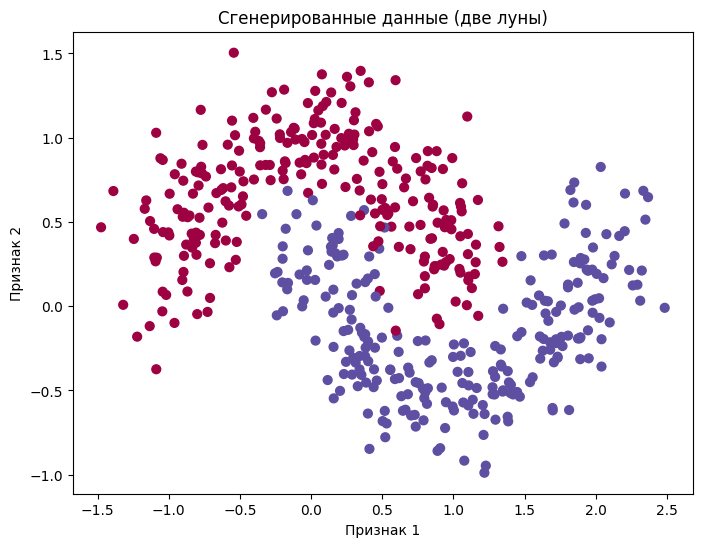

Размерность X_train: (2, 500)
Размерность Y_train: (1, 500)


In [3]:
X, Y = make_moons(n_samples=500, noise=0.2, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.title("Сгенерированные данные (две луны)")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.show()

X_train = X.T
Y_train = Y.reshape(1, Y.shape[0])

print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность Y_train: {Y_train.shape}")

## 4. Определение архитектуры и обучение сети

In [4]:
input_size = X_train.shape[0]
output_size = Y_train.shape[0]
layer_dims = [input_size, 5, 3, output_size]
activation_funcs = ['relu', 'relu', 'sigmoid']
learning_rate = 0.1
epochs = 10000
batch_size = 64

nn = NeuralNetwork(layer_dims, activation_funcs, learning_rate)
costs = nn.fit(X_train, Y_train, epochs, batch_size, print_cost_every=1000)

Эпоха 0: стоимость = 0.694673
Эпоха 1000: стоимость = 0.054785
Эпоха 2000: стоимость = 0.055196
Эпоха 3000: стоимость = 0.051961
Эпоха 4000: стоимость = 0.052535
Эпоха 5000: стоимость = 0.051803
Эпоха 6000: стоимость = 0.051996
Эпоха 7000: стоимость = 0.052894
Эпоха 8000: стоимость = 0.050411
Эпоха 9000: стоимость = 0.051034
Эпоха 9999: стоимость = 0.051785


## 5. Визуализация функции потерь

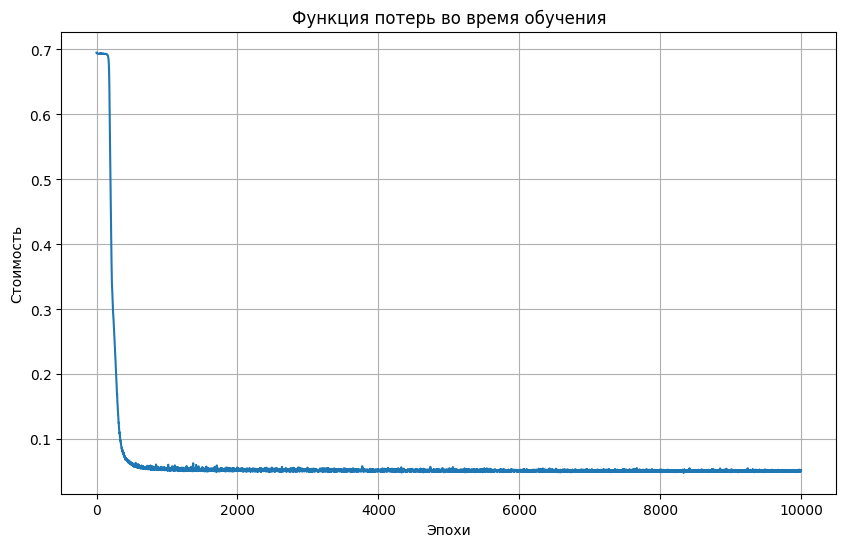

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(costs)
plt.title("Функция потерь во время обучения")
plt.xlabel("Эпохи")
plt.ylabel("Стоимость")
plt.grid(True)
plt.show()

## 6. Визуализация границы решений

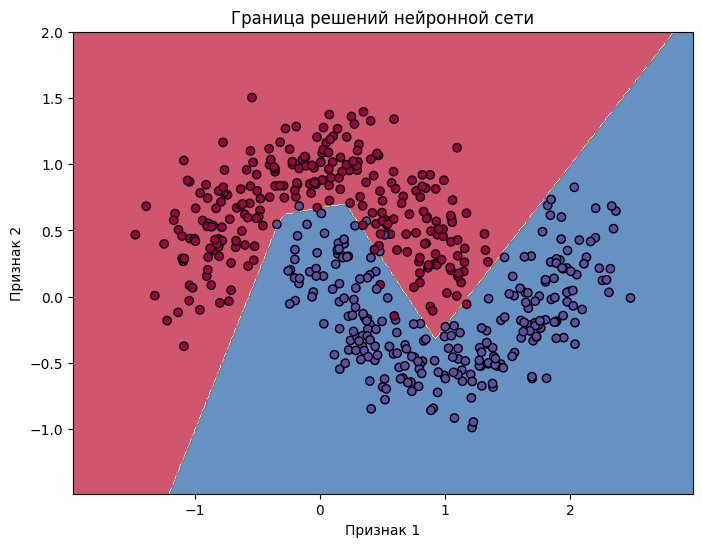

In [6]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
    y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_input = np.c_[xx.ravel(), yy.ravel()].T
    Z = model.predict(grid_input)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral, edgecolors='k')
    plt.title("Граница решений нейронной сети")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    plt.show()

plot_decision_boundary(nn, X_train, Y_train)

## 7. Оценка точности (Accuracy)

In [7]:
predictions = nn.predict(X_train)
accuracy = np.mean(predictions == Y_train) * 100
print(f"Точность на обучающем наборе: {accuracy:.2f}%")

Точность на обучающем наборе: 98.00%
